# Introduction

According to Michael E. Edleson's book, [value averaging](https://en.wikipedia.org/wiki/Value_averaging) method is an enhanced version of the dollar cost averaging method.

It performs better in a mixed market with high volatlity because it tends to secure the gains and buy more dips.

Here we are going to backtest the value averaging strategy using the SP500 index historical data.

# Prepare data and define functions

In [1]:
# Import libraries
import datetime
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [2]:
# Get historical data
startdate = datetime.datetime(1988, 1, 1)
enddate = datetime.datetime(2021, 1, 1)

# Pick SP 500 total return index
SP = pdr.get_data_yahoo('^SP500TR', start=startdate, end=enddate)
SP['date'] = SP.index

In [3]:
# Group by year
SP['year'] = SP['date'].apply(lambda d: f'{d.year}')
df = SP[['year', 'Adj Close']].groupby('year').first()
df['return'] = df['Adj Close'].pct_change() # return rate for last year's investment
df['return_next_y'] = df['return'].shift(-1) # return rate by the begining of next year
df = df.reset_index()
df = df.drop(columns='return')

# You can use the following group by dataframe if you want to do value averging monthly or quarterly
# # Group by month
# SP['month'] = SP['date'].apply(lambda d: f'{d.month:02d}')
# df_m = SP[['year', 'month', 'Adj Close']].groupby(['year','month']).first()
# df_m['return'] = df_m['Adj Close'].pct_change()
# df_m['return_next'] = df_m['return'].shift(-1)
# df_m = df_m.reset_index()
# df_m = df_m.drop(columns='return')

# # Group by quarter
# SP['quarter'] = SP['month'].apply(lambda m: int(m)//4 + 1)
# df_q = SP[['year', 'quarter', 'Adj Close']].groupby(['year','quarter']).first()
# df_q['return'] = df_q['Adj Close'].pct_change()
# df_q['return_next'] = df_q['return'].shift(-1)
# df_q = df_q.reset_index()
# df_q = df_q.drop(columns='return')

In [4]:
df

,year,Adj Close,return_next_y
0,1988,256.019989,0.115733
1,1989,285.649994,0.351864
2,1990,386.160004,-0.058836
3,1991,363.440002,0.320273
4,1992,479.839996,0.075358
5,1993,516.000000,0.099031
6,1994,567.099976,0.014848
7,1995,575.520020,0.386954
8,1996,798.219971,0.214014
9,1997,969.049988,0.346721


In [5]:
def calc_value_averaging_return(df: pd.DataFrame, value_per_period: float = 1.0, 
                                increase_investment_per_period: float = 0.0,
                                display_irr: bool = True) -> pd.DataFrame:
    """
    This function calculates the internal rate of return of the value averaging strategy.
    It also returns a dataframe that contains the amount of money should invest or withdraw per period.
    :param df: Original dataframe that contains the price at the beginning of each period
    :param value_per_period: Investment value per period
    :param increase_investment_per_period: Increase the investment by x each period
    :param display_irr: Whether to display IRR results or not
    :return: A dataframe that contains all the relevant info
    """
    df_va = pd.DataFrame.copy(df)
    value = value_per_period
    df_va.loc[0,'target_value'] = value
    df_va.loc[0,'shares_should_have_in_total'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'shares_to_buy_or_sell'] = value_per_period/df_va.loc[0,'Adj Close']
    df_va.loc[0,'should_invest_or_withdraw'] = value
    df_va.loc[0,'total_invest_or_withdraw'] = value

    for i in range(1,len(df_va.index)):
        value += value_per_period*((1 + increase_investment_per_period)**i)
        df_va.loc[i,'target_value'] = value
        df_va.loc[i,'shares_should_have_in_total'] = df_va.loc[i,'target_value']/df_va.loc[i,'Adj Close']
        df_va.loc[i,'shares_to_buy_or_sell'] = df_va.loc[i,'shares_should_have_in_total'] - df_va.loc[i-1,'shares_should_have_in_total']
        df_va.loc[i,'should_invest_or_withdraw'] = df_va.loc[i,'shares_to_buy_or_sell']*df_va.loc[i,'Adj Close']
        df_va.loc[i,'total_invest_or_withdraw'] = df_va.loc[i-1,'total_invest_or_withdraw'] + df_va.loc[i,'should_invest_or_withdraw']

    if display_irr:
        cf = (-df_va['should_invest_or_withdraw']).tolist()
        cf[-1] = (df_va.loc[len(df_va.index)-2,'shares_should_have_in_total'] *
                    df_va.loc[len(df_va.index)-1,'Adj Close'])
        print("The cash flow (the negative sign stands for investment):")
        display(cf)
        irr = round(100*np.irr(cf), 2)
        print(f"The internal return rate is {irr}% per period")
        
    return df_va


In [6]:
def calc_buy_only_value_averaging_return(df: pd.DataFrame, value_per_period: float = 1.0, 
                                         increase_investment_per_period: float = 0.0,
                                         min_investment_per_period: float = 0.0,
                                         max_investment_per_period: float = 5.0,
                                         display_returns: bool = True) -> pd.DataFrame:
    """
    This function calculates the overall return rate and the internal return rate of the 
    buy only value averaging strategy, with a minimum and maximum investment amount per period.
    It also returns a dataframe that contains the amount of money should invest per peiod. 
    :param df: Original dataframe that contains the price at the beginning of each period
    :param value_per_period: Investment value per period
    :param increase_investment_per_period: Increase the investment by x each period
    :param min_investment_per_period: minimum investment amount at the beginning of each period
    :param max_investment_per_period: maximum investment amount at the beginning of each period
    :param display_returns: Whether to display return results or not
    :return: A dataframe that contains all the relevant info
    """
    df_va = pd.DataFrame.copy(df)
    value = value_per_period
    shares = value_per_period/df_va.loc[0, 'Adj Close']
    df_va.loc[0, 'target_value'] = value   # target value to reach at the beginning of each period
    df_va.loc[0, 'target_shares'] = shares # target share to have at the beginning of each period
    df_va.loc[0, 'current_shares'] = 0     # current shares before the period
    df_va.loc[0, 'shares_to_buy'] = shares # shares to add based on the target
    df_va.loc[0, 'total_shares'] = shares  # total shares after the investment at the beginning of each period
    df_va.loc[0, 'should_invest'] = value  # investment at the beginning of each period
    df_va.loc[0, 'total_invest'] = value   # total amount of investment including this period
    df_va.loc[0, 'total_value'] = value    # total share values after the investment at the beginning of each period
    df_va.loc[0, 'total_value_next'] = df_va.loc[0, 'total_value'] * (1 + df_va.loc[0, 'return_next_y'])
    df_va.loc[0, 'overall_return_next'] = df_va.loc[0, 'total_value_next']/df_va.loc[0, 'total_invest'] - 1
    
    for i in range(1,len(df_va.index)):
        df_va.loc[i, 'current_shares'] = df_va.loc[i-1, 'total_shares']
        
        value += value_per_period*((1 + increase_investment_per_period)**i)
        df_va.loc[i,'target_value'] = value
        df_va.loc[i,'target_shares'] = df_va.loc[i,'target_value']/df_va.loc[i,'Adj Close']
        df_va.loc[i,'shares_to_buy'] = df_va.loc[i,'target_shares'] - df_va.loc[i,'current_shares']
        df_va.loc[i,'should_invest'] = df_va.loc[i,'shares_to_buy'] * df_va.loc[i, 'Adj Close']
        
        if df_va.loc[i, 'should_invest'] < min_investment_per_period:
            df_va.loc[i, 'should_invest'] = min_investment_per_period
            df_va.loc[i, 'shares_to_buy'] = min_investment_per_period/df_va.loc[i,'Adj Close']
            
        elif df_va.loc[i, 'should_invest'] > max_investment_per_period:
            df_va.loc[i, 'should_invest'] = max_investment_per_period
            df_va.loc[i, 'shares_to_buy'] = max_investment_per_period/df_va.loc[i,'Adj Close']
        
        df_va.loc[i, 'total_shares'] = df_va.loc[i-1, 'total_shares'] + df_va.loc[i, 'shares_to_buy']
        df_va.loc[i, 'total_invest'] = df_va.loc[i-1, 'total_invest'] + df_va.loc[i, 'should_invest']
        
        df_va.loc[i, 'total_value'] = df_va.loc[i, 'total_shares']*df_va.loc[i, 'Adj Close']
        
        df_va.loc[i, 'total_value_next'] = df_va.loc[i, 'total_value'] * (1 + df_va.loc[i, 'return_next_y'])
    
        df_va.loc[i, 'overall_return_next'] = df_va.loc[i, 'total_value_next']/df_va.loc[i, 'total_invest'] - 1
        
    if display_returns:     

        # Calculate IRR
        cf = (-df_va['should_invest']).tolist()
        cf[-1] = df_va.loc[len(df_va.index) - 2, 'total_value_next']
        print("The cash flow (the negative sign stands for investment):")
        display(cf)
        irr = round(100*np.irr(cf), 2)
        print(f"The internal return rate is {irr}% per period")
              
        # Calculate overall return
        overall_return = round(df_va.loc[len(df_va.index) - 2, 'overall_return_next']*100, 2)
        print(f"The overall return rate (IRR) is {overall_return}%")
        
        # Calculate CAGR
        cagr = round(100*((df_va.loc[len(df_va.index) - 2, 'total_value_next']/
                           df_va.loc[len(df_va.index) - 2, 'total_invest'])**(1/(len(df_va.index) - 1)) - 1), 2)
        print(f"The compound annual growth rate (CAGR) is {cagr}% per period")
        
    return df_va


In [7]:
def calc_dollar_cost_averaging_return(df: pd.DataFrame, value_per_period: float = 1.0, 
                                      increase_investment_per_period: float = 0.0,
                                      display_returns: bool = True) -> pd.DataFrame:
    """
    This function calculates the overall rate of return and the internal rate of return of dollar cost averaging method. 
    :param df: Original dataframe that contains the price at the beginning of each period
    :param value_per_period: Investment value per period
    :param increase_investment_per_period: Increase the investment by x each period
    :param display_returns: Whether to display return results or not
    :return: A dataframe that contains all the relevant info
    """
    df_dc = pd.DataFrame.copy(df)
    # amount to invest each period
    df_dc.loc[0, 'should_invest'] = value_per_period   
    # total amount of investment after the investment this period
    df_dc.loc[0, 'total_invest'] = value_per_period   
    # the total value by the beginning of next period
    df_dc.loc[0, 'total_value_next'] = value_per_period*(1 + df_dc.loc[0, 'return_next_y'])
    df_dc.loc[0, 'overall_return_next'] = df_dc.loc[0, 'total_value_next'] / df_dc.loc[0, 'total_invest'] - 1

    for i in range(1,len(df_dc.index)):
        df_dc.loc[i, 'should_invest'] = value_per_period * (1 + increase_investment_per_period)**i
        df_dc.loc[i, 'total_invest'] = df_dc.loc[i-1, 'total_invest'] + df_dc.loc[i, 'should_invest']
        df_dc.loc[i, 'total_value_next'] = ((df_dc.loc[i-1, 'total_value_next'] + 
                                            df_dc.loc[i, 'should_invest']) *
                                            (1 + df_dc.loc[i, 'return_next_y']) 
                                           )
        df_dc.loc[i, 'overall_return_next'] = df_dc.loc[i, 'total_value_next'] / df_dc.loc[i, 'total_invest'] - 1
        
    if display_returns:
        
        # Calculate IRR
        cf = (-df_dc['should_invest']).tolist()
        cf[-1] = df_dc.loc[len(df_dc.index) - 2, 'total_value_next']
        print("The cash flow (the negative sign stands for investment):")
        display(cf)
        irr = round(100*np.irr(cf), 2)
        print(f"The internal return rate (IRR) is {irr}% per period")
                
        # Calculate overall return
        overall_return = round(df_dc.loc[len(df_dc.index) - 2, 'overall_return_next']*100, 2)
        print(f"The overall return rate is {overall_return}%")
        
        # Calculate CAGR
        cagr = round(100*((df_dc.loc[len(df_dc.index) - 2, 'total_value_next']/
                           df_dc.loc[len(df_dc.index) - 2, 'total_invest'])**(1/(len(df_dc.index) - 1)) - 1), 2)
        print(f"The compound annual growth rate (CAGR) is {cagr}% per period")
        
    return df_dc


def plot_changes(df: pd.DataFrame,
                 y1: str = 'total_invest', y2: str = 'total_value_next',
                 title: str = 'Visualize total investment and value each year') -> None:
    """
    This function visualizes the total investment and the total value of the investment plan across time
    :param df: A dataframe contains total investment and total value
    :param y1: Column name
    :param y2: Column name
    :param title: Title of the graph
    :return: A plot
    """
    plt.figure(figsize=(15, 5))
    plt.plot(df[y1], label=y1)
    plt.plot(df[y2], label=y2)
    plt.xlabel('period')
    plt.ylabel('value')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend()
    plt.show()

# Plan 1: Value averaging method

In [8]:
df_va1 = calc_value_averaging_return(df, value_per_period=1200)

The cash flow (the negative sign stands for investment):


[-1200.0,
 -1061.1201961364186,
 -355.52589325481887,
 -1411.8085861271627,
 337.31005654283166,
 -747.849233851947,
 -486.97708484738405,
 -1075.2805992143667,
 2514.761361370703,
 1111.3480648011666,
 2960.6528724251534,
 2476.466314117218,
 1679.0158053734597,
 -2884.972366494456,
 -2680.227795866851,
 -4795.998397092098,
 3439.2227337015943,
 904.3614871476314,
 421.54897775958983,
 1948.1048236273016,
 -216.55745519229592,
 -9782.193899045382,
 5278.448809688893,
 2809.6319858651427,
 -471.3483862548249,
 3947.1013032192404,
 7523.195663896054,
 3551.4295421831143,
 -1241.8135883408345,
 3895.1078797634023,
 6652.273617097743,
 -3080.564625962192,
 50855.361827168424]

The internal return rate is 12.12% per period


In [9]:
df_va1

,year,Adj Close,return_next_y,target_value,shares_should_have_in_total,shares_to_buy_or_sell,should_invest_or_withdraw,total_invest_or_withdraw
0,1988,256.019989,0.115733,1200.0,4.687134,4.687134,1200.000000,1200.000000
1,1989,285.649994,0.351864,2400.0,8.401891,3.714757,1061.120196,2261.120196
2,1990,386.160004,-0.058836,3600.0,9.322561,0.920670,355.525893,2616.646089
3,1991,363.440002,0.320273,4800.0,13.207132,3.884571,1411.808586,4028.454676
4,1992,479.839996,0.075358,6000.0,12.504168,-0.702964,-337.310057,3691.144619
5,1993,516.000000,0.099031,7200.0,13.953488,1.449320,747.849234,4438.993853
6,1994,567.099976,0.014848,8400.0,14.812203,0.858715,486.977085,4925.970938
7,1995,575.520020,0.386954,9600.0,16.680567,1.868364,1075.280599,6001.251537
8,1996,798.219971,0.214014,10800.0,13.530105,-3.150462,-2514.761361,3486.490176
9,1997,969.049988,0.346721,12000.0,12.383262,-1.146843,-1111.348065,2375.142111


In the last notebook, we already know that the IRR for dollar cost averaging is below 10% per year. Using the same test data, the IRR of the value averaging method is about 12% per year, which supports our hypothesis.

However, we can also observe that, because we are taking money out from the investment plan, the final value of the value averaging is way below that of the dollar cost averaing.

so the value averaging method is not really a good one for long term investment.

In the last notebook, if we invest 1200 dollar per year starting from 1988 and by 2019, we will have about 261192 dollar. 

If we want to accumulate the same amount of money using the value averaging, we need to invest more for each year.

Let's check the IRR if we increase the investment each year by 10%. 


# Plan 2: Increase investment each year by 10%

In [10]:
df_va2 = calc_value_averaging_return(df, value_per_period=1200, 
                                     increase_investment_per_period=0.1)

The cash flow (the negative sign stands for investment):


[-1200.0,
 -1181.1201961364188,
 -565.3021879175599,
 -1830.8954733603034,
 26.743993103820433,
 -1380.5268715179054,
 -1208.9720776032202,
 -2169.4270511041677,
 2737.892833854878,
 657.8958460156231,
 3518.5181924009958,
 2769.824630978246,
 1364.3601939671873,
 -7321.194096811861,
 -7514.80857127775,
 -12629.617352887119,
 4909.707669716029,
 -1046.4989781541021,
 -2564.0511882120322,
 1137.4449047712715,
 -5256.666376415341,
 -35036.57899214694,
 11257.990836019511,
 3121.7177152010245,
 -9132.857546202227,
 7246.443979130866,
 22329.4920899403,
 5579.038139518119,
 -17505.61372633736,
 7077.75812974924,
 22115.78642833783,
 -34070.51321757376,
 319654.1856549351]

The internal return rate is 11.21% per period


In [11]:
df_va2

,year,Adj Close,return_next_y,target_value,shares_should_have_in_total,shares_to_buy_or_sell,should_invest_or_withdraw,total_invest_or_withdraw
0,1988,256.019989,0.115733,1200.000000,4.687134,4.687134,1200.000000,1200.000000
1,1989,285.649994,0.351864,2520.000000,8.821985,4.134851,1181.120196,2381.120196
2,1990,386.160004,-0.058836,3972.000000,10.285892,1.463907,565.302188,2946.422384
3,1991,363.440002,0.320273,5569.200000,15.323575,5.037683,1830.895473,4777.317857
4,1992,479.839996,0.075358,7326.120000,15.267839,-0.055735,-26.743993,4750.573864
5,1993,516.000000,0.099031,9258.732000,17.943279,2.675440,1380.526872,6131.100736
6,1994,567.099976,0.014848,11384.605200,20.075129,2.131850,1208.972078,7340.072813
7,1995,575.520020,0.386954,13723.065720,23.844637,3.769508,2169.427051,9509.499865
8,1996,798.219971,0.214014,16295.372292,20.414639,-3.429998,-2737.892834,6771.607031
9,1997,969.049988,0.346721,19124.909521,19.735731,-0.678908,-657.895846,6113.711185


With the increased amount of investment, the IRR of value averaging Plan 2 is still higher than that of the dollar cost averaging method. 

However, there is a drawback of the value averaging method:

If we check the cashflow, we can see that, whenever there is a market crash (especially at the lates stage of the investment), we need to invest a huge amount of money in order to catch up (e.g., 2019)

What if we adjust the value averaging method into a buy and hold strategy? We can also set a minimum and maximum investment value per period.

# Plan 3: No selling, with minimum and maximum investment pre period

In [13]:
df_va3 = calc_buy_only_value_averaging_return(df, value_per_period=1200, 
                                             increase_investment_per_period=0.10,
                                             min_investment_per_period=600,
                                             max_investment_per_period=6000)

The cash flow (the negative sign stands for investment):


[-1200.0,
 -1181.1201961364188,
 -600.0,
 -1798.239131977554,
 -600.0,
 -706.552415637322,
 -1208.9720776032202,
 -2169.4270511041677,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -6000.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -1922.6955641279228,
 -6000.0,
 -6000.0,
 -6000.0,
 -6000.0,
 -6000.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 -600.0,
 328826.905866578]

The internal return rate is 10.54% per period
The overall return rate (IRR) is 471.01%
The compound annual growth rate (CAGR) is 5.6% per period


We can see here that the IRR is still higher than the dollar averaging method, but the overall return by the next period still performs poorer compared to the dollar cost averaging method.

In [14]:
df_va3

,year,Adj Close,return_next_y,target_value,target_shares,current_shares,shares_to_buy,total_shares,should_invest,total_invest,total_value,total_value_next,overall_return_next
0,1988,256.019989,0.115733,1200.000000,4.687134,0.000000,4.687134,4.687134,1200.000000,1200.000000,1200.000000,1338.879804,0.115733
1,1989,285.649994,0.351864,2520.000000,8.821985,4.687134,4.134851,8.821985,1181.120196,2381.120196,2520.000000,3406.697812,0.430712
2,1990,386.160004,-0.058836,3972.000000,10.285892,8.821985,1.553760,10.375745,600.000000,2981.120196,4006.697812,3770.960868,0.264948
3,1991,363.440002,0.320273,5569.200000,15.323575,10.375745,4.947829,15.323575,1798.239132,4779.359328,5569.200000,7352.863993,0.538462
4,1992,479.839996,0.075358,7326.120000,15.267839,15.323575,1.250417,16.573991,600.000000,5379.359328,7952.863993,8552.179584,0.589814
5,1993,516.000000,0.099031,9258.732000,17.943279,16.573991,1.369288,17.943279,706.552416,6085.911744,9258.732000,10175.633122,0.671998
6,1994,567.099976,0.014848,11384.605200,20.075129,17.943279,2.131850,20.075129,1208.972078,7294.883821,11384.605200,11553.638669,0.583800
7,1995,575.520020,0.386954,13723.065720,23.844637,20.075129,3.769508,23.844637,2169.427051,9464.310872,13723.065720,19033.265126,1.011057
8,1996,798.219971,0.214014,16295.372292,20.414639,23.844637,0.751672,24.596309,600.000000,10064.310872,19633.265126,23835.053029,1.368275
9,1997,969.049988,0.346721,19124.909521,19.735731,24.596309,0.619163,25.215472,600.000000,10664.310872,24435.053029,32907.200827,2.085732


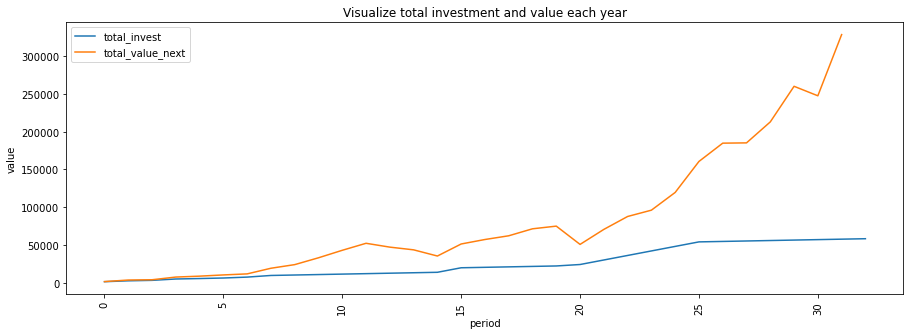

In [16]:
plot_changes(df_va3)

# Compare with dollar cost averaging

In [26]:
df_dc = calc_dollar_cost_averaging_return(df, value_per_period=1200, 
                                          increase_investment_per_period=0.02)

The cash flow (the negative sign stands for investment):


[-1200.0,
 -1224.0,
 -1248.48,
 -1273.4496000000001,
 -1298.918592,
 -1324.8969638400001,
 -1351.3949031168002,
 -1378.422801179136,
 -1405.991257202719,
 -1434.1110823467732,
 -1462.7933039937088,
 -1492.049170073583,
 -1521.8901534750546,
 -1552.327956544556,
 -1583.374515675447,
 -1615.042005988956,
 -1647.3428461087349,
 -1680.2897030309098,
 -1713.8954970915281,
 -1748.1734070333584,
 -1783.1368751740258,
 -1818.7996126775063,
 -1855.1756049310566,
 -1892.2791170296778,
 -1930.1246993702714,
 -1968.7271933576767,
 -2008.1017372248302,
 -2048.263771969327,
 -2089.2290474087135,
 -2131.0136283568877,
 -2173.633900924026,
 -2217.106578942506,
 311273.63335198513]

The internal return rate (IRR) is 9.91% per period
The overall return rate is 486.51%
The compound annual growth rate (CAGR) is 5.68% per period


In [27]:
df_dc

,year,Adj Close,return_next_y,should_invest,total_invest,total_value_next,overall_return_next
0,1988,256.019989,0.115733,1200.000000,1200.000000,1338.879804,0.115733
1,1989,285.649994,0.351864,1224.000000,2424.000000,3464.665484,0.429317
2,1990,386.160004,-0.058836,1248.480000,3672.480000,4435.844184,0.207861
3,1991,363.440002,0.320273,1273.449600,4945.929600,7537.826024,0.524046
4,1992,479.839996,0.075358,1298.918592,6244.848192,9502.668090,0.521681
5,1993,516.000000,0.099031,1324.896964,7569.745156,11899.829221,0.572025
6,1994,567.099976,0.014848,1351.394903,8921.140059,13447.972306,0.507428
7,1995,575.520020,0.386954,1378.422801,10299.562860,20563.532573,0.996544
8,1996,798.219971,0.214014,1405.991257,11705.554117,26671.303126,1.278517
9,1997,969.049988,0.346721,1434.111082,13139.665200,37850.153571,1.880603


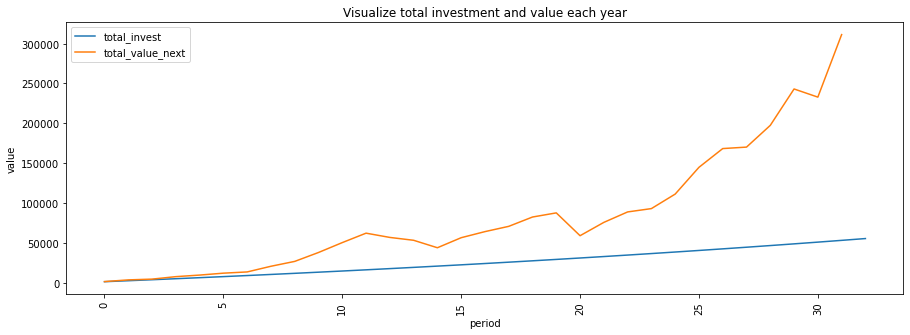

In [28]:
plot_changes(df_dc)

In [30]:
select_columns = ['should_invest', 'total_value_next', 'overall_return_next']
pd.merge(df_dc[select_columns], df_va3[select_columns], 
         left_index=True, right_index=True, 
         suffixes=('_dc', '_va3')).round(2)

,should_invest_dc,total_value_next_dc,overall_return_next_dc,should_invest_va3,total_value_next_va3,overall_return_next_va3
0,1200.00,1338.88,0.12,1200.00,1338.88,0.12
1,1224.00,3464.67,0.43,1181.12,3406.70,0.43
2,1248.48,4435.84,0.21,600.00,3770.96,0.26
3,1273.45,7537.83,0.52,1798.24,7352.86,0.54
4,1298.92,9502.67,0.52,600.00,8552.18,0.59
5,1324.90,11899.83,0.57,706.55,10175.63,0.67
6,1351.39,13447.97,0.51,1208.97,11553.64,0.58
7,1378.42,20563.53,1.00,2169.43,19033.27,1.01
8,1405.99,26671.30,1.28,600.00,23835.05,1.37
9,1434.11,37850.15,1.88,600.00,32907.20,2.09


# Conclusion

Value averaging is a good method to increase IRR, but it does not fit the purpose of long term investment as it takes out the profit too early.

The adjusted version of the value averaging seems to outperform the dollar-cost averaging in the first 10 years. But the difference is not huge.

In the next blogpost, we are going to examine how to invest a fixed amount of money in short term. To be more specfic, we are going to compare the dollar-cost avearging method, value averaging with all-in moethod for short term invesment.